# Active Learning

## Problem setup: 
On an 8x8 gridworld grid, 90% of the squares have no reward and 10% have fixed reward (uniform [0,1]).
The agent normally doesn't see the reward, but it can pay a fixed 'query' cost to see it. 

We use Posterior Sampling Reinforcement Learning to do the learning. We use N(0,1) for the reward distributions.

As a heuristic method, we separate the problem into PSRL and a choice of whether to query at the time an action is chosen. We try several different heuristic query choice functions: 

1. QueryFirstN, queries the first n state action pairs encountered
1. QueryFirstNVisits, queries the first some number of times that it visits a state action pair
2. RewardProportional, probabilistically queries proportionally to the fraction of the total expected reward of the current state action (relative to the total of all pairs).
3. EntropyThreshold, queries based on whether the current distribution has entropy larger than a certain amount

In [1]:
%pylab inline
import numpy as np
import argparse
import gridworld
import query_functions
import finite_tabular_agents

seed = 1#np.random.randint(10000) #1
numpy_rng = np.random.RandomState(seed)

from feature_extractor import FeatureTrueState
from experiment import run_finite_tabular_experiment

# AGENT

Populating the interactive namespace from numpy and matplotlib


In [2]:
def runexp(nEps, epLen, scaling, alg, grid_width, prob_zero_reward, query_function):
    targetPath = 'test.csv'

    # reward probabilities
    states = range(grid_width**2)
    reward_probabilities = numpy_rng.binomial(1, 1 - prob_zero_reward, len(states)) * numpy_rng.uniform(0, 1, len(states))

    # Make the environment
    env = gridworld.make_gridworld(grid_width, epLen, reward_probabilities)

    f_ext = FeatureTrueState(env.epLen, env.nState, env.nAction, env.nState)

    # Make the agent
    agent = alg(env.nState, env.nAction, env.epLen,
                              scaling=scaling, 
                              P_true=env.P, R_true=False)
    query_function.setEnvAgent(env, agent)

    # Run the experiment
    return run_finite_tabular_experiment(agent, env, f_ext, nEps, seed,
                        recFreq=1000, fileFreq=10000, targetPath=targetPath, query_function=query_function)

We first look at the performance of EpsilonGreedy assuming no query costs.

In [3]:
iters = 20
nvisitsExperiments = lambda x : [ runexp(
    nEps=50,
    epLen = 15,
    scaling = 1,
    alg = finite_tabular_agents.EpsilonGreedy,
    grid_width = 8, #8x8 grid, 
    prob_zero_reward = .9,
    query_function = query_functions.QueryFirstNVisits(2, x)
    ) for i in range(iters)]

ns = [0,1,2,4,8,12]
ys = map(nvisitsExperiments,ns)

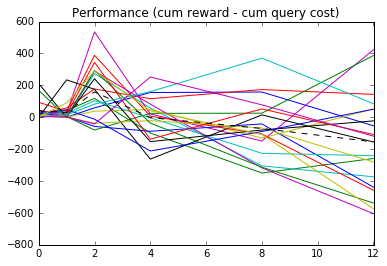

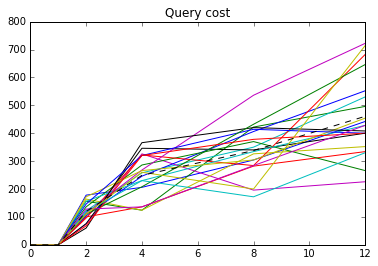

In [17]:
x = np.array(ys)[:,:,2]
plot(ns, x);
plot(ns, np.mean(x, axis=1), '--');
title("Performance (cum reward - cum query cost)");

figure()
queryCost = np.array(ys)[:,:,1]
plot(ns, queryCost);
plot(ns, np.mean(queryCost, axis=1), '--');
title("Query cost");

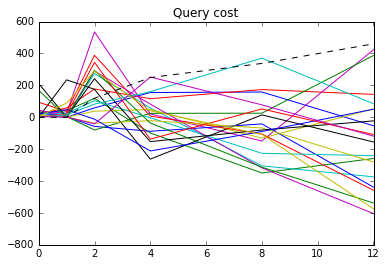

In [15]:
queryCost = np.array(ys)[:,:,1]
plot(ns, queryCost);
plot(ns, np.mean(queryCost, axis=1), '--');
title("Query cost");

We see that Epsilon Greedy is super noisy, but shows a peak at sampling 2 times at every point, then getting worse steadily.

PSRL
----
The same experiment.

In [18]:
iters = 20
nvisitsExperiments = lambda x : [ runexp(
    nEps=50,
    epLen = 15,
    scaling = 1,
    alg = finite_tabular_agents.PSRL,
    grid_width = 8,
    prob_zero_reward = .9,
    query_function = query_functions.QueryFirstNVisits(2, x)
    ) for i in range(iters)]

ns = [0,1,2,4,8,12]
ys = map(nvisitsExperiments,ns)

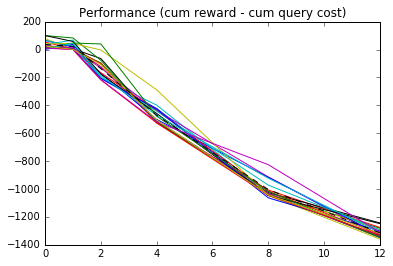

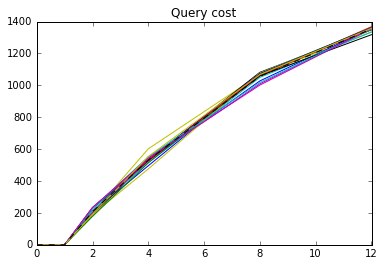

In [19]:
x = np.array(ys)[:,:,2]
plot(ns, x);
plot(ns, np.mean(x, axis=1), '--');
title("Performance (cum reward - cum query cost)");

figure()
queryCost = np.array(ys)[:,:,1]
plot(ns, queryCost);
plot(ns, np.mean(queryCost, axis=1), '--');
title("Query cost");

Surprisingly PSRL seems to perform worse than Epsilon Greedy. We're not sure what's happening here. 

The query costs rise fster for PSRL, so there seems to be some sense in which PSRL is over exploring here. This is surprising because if anything, PSRL should be underestimating the average rewards. 

Now we run similar experiments but with different query functions

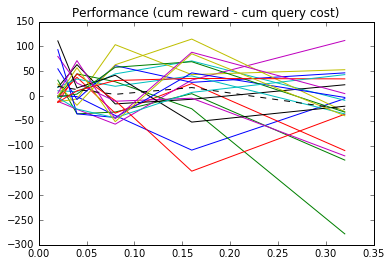

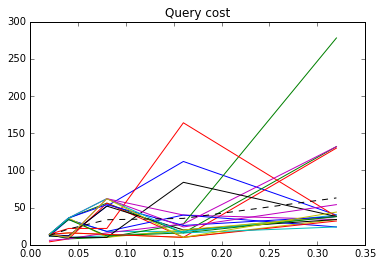

In [20]:
iters = 20
nvisitsExperiments = lambda x : [ runexp(
    nEps=50,
    epLen = 15,
    scaling = 1,
    alg = finite_tabular_agents.PSRL,
    grid_width = 8,
    prob_zero_reward = .9,
    query_function = query_functions.RewardProportional(2, x)
    ) for i in range(iters)]

ns = [.02,.04,.08,.16,.32]
ys = map(nvisitsExperiments,ns)

x = np.array(ys)[:,:,2]
plot(ns, x);
plot(ns, np.mean(x, axis=1), '--');
title("Performance (cum reward - cum query cost)");

figure()
queryCost = np.array(ys)[:,:,1]
plot(ns, queryCost);
plot(ns, np.mean(queryCost, axis=1), '--');
title("Query cost");

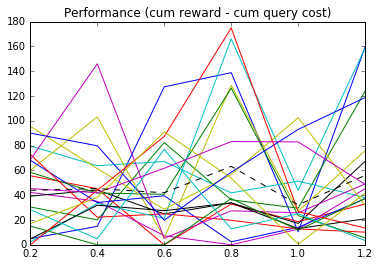

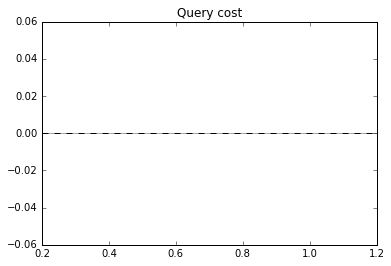

In [25]:
iters = 20
nvisitsExperiments = lambda x : [ runexp(
    nEps=50,
    epLen = 15,
    scaling = 1,
    alg = finite_tabular_agents.PSRL,
    grid_width = 8,
    prob_zero_reward = .9,
    query_function = query_functions.EntropyThreshold(2, x)
    ) for i in range(iters)]

ns = [.2, .4, .6,.8,1,1.2]
ys = map(nvisitsExperiments,ns)

x = np.array(ys)[:,:,2]
plot(ns, x);
plot(ns, np.mean(x, axis=1), '--');
title("Performance (cum reward - cum query cost)");

figure()
queryCost = np.array(ys)[:,:,1]
plot(ns, queryCost);
plot(ns, np.mean(queryCost, axis=1), '--');
title("Query cost");

In [3]:
%load_ext line_profiler


In [5]:
%lprun -f finite_tabular_agents.FiniteHorizonTabularAgent.compute_qVals runexp(nEps=50,epLen = 15,scaling = 1,alg = finite_tabular_agents.PSRL, grid_width = 8,prob_zero_reward = .9,query_function = query_functions.EntropyThreshold(2, .5) )